In [13]:
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import warnings
import os
warnings.filterwarnings("ignore")

In [14]:
from datasets.classification.ucf101 import UCF101
from datasets.classification.hmdb51 import HMDB51

In [15]:
from utils.transforms import (
    Compose, RandomCrop3D, CenterCrop3D, RandomHorizontalFlip3D, ToTensor3D, Normalize3D,
    TemporalRandomCrop, LoopPadding)

In [16]:
spatial_transform = {
        "train": Compose(
            [
                RandomCrop3D(transform2D=transforms.RandomCrop(
                    size=(112, 112))
                ),
                RandomHorizontalFlip3D(),
                ToTensor3D()
            ]
        ),
        "test": Compose(
            [
                CenterCrop3D((112, 112)),
                ToTensor3D()
            ]
        )
}

temporal_transform = {
    "train": TemporalRandomCrop(size=16),
    "test": LoopPadding(16)
}

norm_method = Normalize3D(
        mean=[
    0.43216,
    0.394666,
    0.37645
  ],
        std=[
    0.22803,
    0.22145,
    0.216989
  ]
    )

In [17]:
ds = UCF101(root='/data/torch_data/UCF-101/video', 
            annotation_path='/data/torch_data/UCF-101/ucfTrainTestlist/',
            detection_file_path='/data/torch_data/UCF-101/detection_rcnn.txt',
            sample_rate=5, img_size=(128, 171), train=True, fold=1,
            temporal_transform=temporal_transform["train"],
            spatial_transform=spatial_transform["train"],
            norm_method=norm_method)
len(ds)

9537

In [ ]:
ds = HMDB51(root='/data/torch_data/HMDB51/video', 
            annotation_path='/data/torch_data/HMDB51/testTrainMulti_7030_splits/',
            detection_file_path='/data/torch_data/HMDB51/detection_rcnn.txt',
            sample_rate=5, img_size=(128, 171), train=True, fold=1,
            temporal_transform=temporal_transform["train"],
            spatial_transform=spatial_transform["train"],
            norm_method=norm_method)
len(ds)

# Explore video & mask

In [21]:
video, mask, label = ds[500]
print("label : ", ds.classes[label])
# ('/data/torch_data/UCF-101/video/ApplyEyeMakeup/v_ApplyEyeMakeup_g13_c04.avi', 0)

label :  BandMarching


In [22]:
def denormalize_image(img, mean=[
    0.43216,
    0.394666,
    0.37645
  ], std=[
    0.22803,
    0.22145,
    0.216989
  ]):
    mean = torch.tensor(mean).view(-1,1,1)
    std = torch.tensor(std).view(-1,1,1)
    
    # img : (3,H,W)
    return img * std + mean

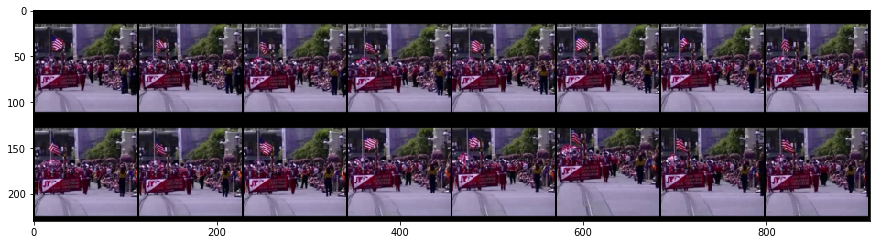

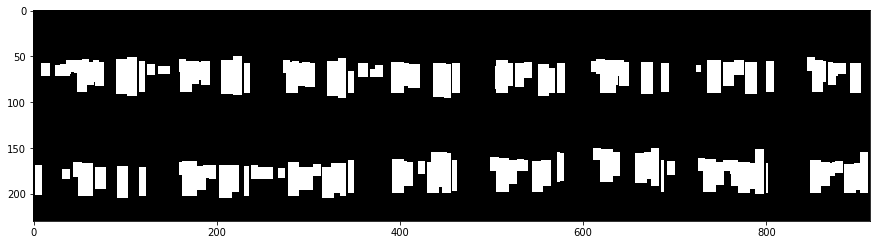

In [23]:
import matplotlib.pyplot as plt

def show_grid_plot(data, denorm=True):
    res = []
    for i in range(data.size(1)):
        img = data[:, i]
        if denorm:
            img = denormalize_image(img)
        res.append(img)

    grid_img = torchvision.utils.make_grid(torch.stack(res))
    plt.figure(figsize=(15,15))
    plt.imshow(grid_img.permute(1,2,0))
    
show_grid_plot(video, denorm=True)
show_grid_plot(mask, denorm=False)

In [9]:
video.shape

torch.Size([3, 16, 112, 112])

In [ ]:
mask.shape

# Model implementation

In [ ]:
len(ucf_ds)

In [ ]:
torch.__version__

In [ ]:
dict(('train_'+k,v) for k,v in {'a': 0.0, 'b': 3.0}.items())

In [ ]:
class A:
    aa = 3
    def __init__(self):
        print(self.aa)

In [ ]:
A()

In [ ]:
import torch
precision = 'fp32'
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision)

In [ ]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

In [ ]:
ssd_model.to('cuda')
ssd_model.eval()

In [ ]:
# uris = [
#     'http://images.cocodataset.org/val2017/000000397133.jpg',
#     'http://images.cocodataset.org/val2017/000000037777.jpg',
#     'http://images.cocodataset.org/val2017/000000252219.jpg'
# ]

In [ ]:
uris = [ f"/data/torch_data/frames/I_DO_NOT_Run_Up_Stairs_Like_A_GIRL_climb_stairs_l_cm_np1_ba_med_0/thumb{t:04d}.jpg" for t in range(1, 50)]

In [ ]:
inputs = [utils.prepare_input(uri) for uri in uris]
tensor = utils.prepare_tensor(inputs, precision == 'fp16')

In [ ]:
%%timeit
with torch.no_grad():
    detections_batch = ssd_model(tensor)

In [ ]:
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]

In [ ]:
classes_to_labels = utils.get_coco_object_dictionary()

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # Show original, denormalized image...
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()